# Preparation

## Requirment

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchaudio
from torchaudio import transforms
import math, copy, time, random, os
import numpy as np
import scipy.io as sio
import scipy.sparse as sp
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from warmup_scheduler import GradualWarmupScheduler
from einops import rearrange
from tqdm import tqdm
import shutil
from pathlib import Path


## Config

In [ ]:
class Config:
    def __init__(self, subject: str = '2'):
        # ---------- subject ----------
        self.subject = str(subject)
        self.update_file_name()          # update file_name

        # ---------- dataloading ----------
        self.root: Path = Path('/home/test/Desktop/python/EEG_data/AAD_dataset/AVGC/dataset/dataset_1s')

        self.total_sub = 18
        self.LOO = 1
        self.sample_rate = 16000
        
        # ---------- encoder dim ----------
        self.EEG_encoder_dim = 256
        self.Audio_encoder_dim = 256
        
        # ---------- projector dim ----------
        self.Embedding_dim = 256
        self.Projector_dim = 128
        
        # ---------- EEG/Audio ----------
        self.num_channels = 64
        self.clean_audio_size = 80
        self.noisy_audio_size = 80
        
        # ---------- training ----------
        self.Temperature = 0.1
        self.batch_size = 8
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.weight_decay = 1e-3
        self.EEG_encoder_lr = 2e-4
        self.Audio_encoder_lr = 1e-4
        self.head_lr = 1e-4
        self.patience = 2
        self.factor = 0.8
        self.epochs = 40
        self.dropout = 0.1

    # ---------- helper ----------
    def update_file_name(self):
        self.file_name = f"sub{self.subject}.npz"
    def __repr__(self):
        return (f"Config(subject={self.subject}, file_name={self.file_name}, "
                f"device={self.device}, batch_size={self.batch_size})")

## Prepare Dataset

In [ ]:
def load_data(root, subject):

    """
    加载 EEG 数据、音频数据及对应事件标签
    :param root: 数据根路径
    :param subject: 受试者编号
    :return: eeg_data, attend_audio, audioA_data, audioB_data, event
    """
    # 构建文件路径
    npz_file = os.path.join(root, f"sub{subject}.npz")
    
    # 从 NPZ 文件加载数据
    data = np.load(npz_file)
    
    # 提取数据
    eeg_data = data['eeg_data']          # EEG 数据 (样本数, 64, 128)
    audio_data = data['audio_data']      # 音频数据 (样本数, 3, 128)
    event = data['event_data']           # 事件标签 (样本数,)
    
    # 拆分音频通道
    # 音频数据的三个通道: [0]左声道包络, [1]右声道包络, [2]关注的包络
    audioA_data = audio_data[:, 0, :]    # 左声道 (样本数, 128)
    audioB_data = audio_data[:, 1, :]    # 右声道 (样本数, 128)
    attend_audio = audio_data[:, 2, :]   # 关注的包络 (样本数, 128)
    
    return eeg_data, attend_audio, audioA_data, audioB_data, event

In [ ]:

class EEGDataset(Dataset):
    def __init__(self, config, subject):
        """
        初始化数据集
        :param config: 配置对象，包含数据路径等信息
        :param subject: 受试者编号
        """

        # 加载数据 - 现在返回五个元素
        self.eeg_data, self.attend_audio, self.audioA_data, self.audioB_data, self.event = load_data(
            config.root, subject
        )
        
        # 确保数据长度一致
        assert len(self.eeg_data) == len(self.attend_audio) == len(self.audioA_data) == len(self.audioB_data) == len(self.event)
        
        # 将事件标签转换为torch tensor
        self.event = torch.tensor(self.event, dtype=torch.long)
                # Only keep temporal lobe channels
        self.temporal_indices = [15, 16, 51, 52, 7, 41]  # Corresponding indices of T7, TP7, T8, TP8, FT7, FT8 in channel_names

    
    def __len__(self):
        return len(self.eeg_data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # 处理EEG数据
        eeg = self.eeg_data[idx].astype(np.float32)[self.temporal_indices, :]
#         eeg = self.eeg_data[idx].astype(np.float32)  # (64, 128)/
        eeg = torch.Tensor(eeg)
        
        # 归一化每个通道 (0-1)
        eeg_min, _ = torch.min(eeg, dim=1, keepdim=True)
        eeg_max, _ = torch.max(eeg, dim=1, keepdim=True)
        eeg = (eeg - eeg_min) / (eeg_max - eeg_min + 1e-8)  # 添加小常数避免除以0
        
        # 获取关注的音频作为干净信号
        clean_audio = torch.Tensor(self.attend_audio[idx].astype(np.float32)).unsqueeze(0)  # (1, 128)
        
        # 获取左右声道音频
        wavA = torch.Tensor(self.audioA_data[idx].astype(np.float32)).unsqueeze(0)  # (1, 128)
        wavB = torch.Tensor(self.audioB_data[idx].astype(np.float32)).unsqueeze(0)  # (1, 128)
        
        # 获取事件标签
        event_label = self.event[idx]
        
        return eeg, clean_audio, wavA, wavB, event_label

## Utils

In [4]:
def print_size(net, keyword=None):
    """
    Print the number of parameters of a network
    """

    if net is not None and isinstance(net, torch.nn.Module):
        module_parameters = filter(lambda p: p.requires_grad, net.parameters())
        params = sum([np.prod(p.size()) for p in module_parameters])
        
        print("{} Parameters: {:.6f}M".format(
            net.__class__.__name__, params / 1e6), flush=True, end="; ")
        
        if keyword is not None:
            keyword_parameters = [p for name, p in net.named_parameters() if p.requires_grad and keyword in name]
            params = sum([np.prod(p.size()) for p in keyword_parameters])
            print("{} Parameters: {:.6f}M".format(
                keyword, params / 1e6), flush=True, end="; ")
        
        print(" ")

In [5]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [6]:
def pre_evaluate(dataloader, model):
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for eeg, audio, wavA, wavB, event in dataloader:
            eeg, audio = eeg.to(Config.device), audio.to(Config.device)
            wavA = wavA.to(Config.device)
            wavB = wavB.to(Config.device)
            event = event.to(Config.device)
            event = event.squeeze()
#             print(eeg.shape, audio.shape, wavA.shape, wavB.shape)
            _, pred = model(eeg, audio, wavA, wavB)
            # print(pred)
            _, predicted = torch.max(pred, 1)
            # print(predicted)
            correct += (predicted == event).sum().item()
    accuracy = correct / len(dataloader.dataset)
    return accuracy

In [ ]:
class AutomaticWeightedLoss(nn.Module):
    """automatically weighted multi-task loss
    Params：
        num: int，the number of loss
        x: multi-task loss
    Examples：
        loss1=1
        loss2=2
        awl = AutomaticWeightedLoss(2)
        loss_sum = awl(loss1, loss2)
    """
    def __init__(self, num=2):
        super(AutomaticWeightedLoss, self).__init__()
        params = torch.ones(num, requires_grad=True)
        self.params = torch.nn.Parameter(params)
#         print(self.params)

    def forward(self, *x):
        loss_sum = 0
        length = len(x)-1
        for i, loss in enumerate(x):
            if i == length:
                loss_sum += 1 / (self.params[i] ** 2) * loss + torch.log(self.params[i])
            else:
                loss_sum += 0.5 / (self.params[i] ** 2) * loss + torch.log(self.params[i])
        return loss_sum
        

In [ ]:
# A class for contrastive loss
class ComputeLoss(nn.Module):
    def __init__(self, ):
        super(ComputeLoss, self).__init__()
        self.awl = AutomaticWeightedLoss(2)
        self.classification_loss = nn.CrossEntropyLoss()
       
    def forward(self, simclr_loss, result, event):
        # 计算分类损失
        c_loss = self.classification_loss(result, event)
        total_loss = self.awl(simclr_loss, c_loss)
        return total_loss

# Modle

## SincNet

In [7]:
class SincConv_fast(nn.Module):
    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)

    def __init__(self, out_channels, kernel_size, mode, low_hz = 1, sample_rate=16000, in_channels=1,
                 stride=1, padding=0, dilation=1, bias=False, groups=1, min_low_hz=1, min_band_hz=4):
        super(SincConv_fast,self).__init__()
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        # Forcing the filters to be odd (i.e, perfectly symmetrics)
        if kernel_size%2==0:
            self.kernel_size=self.kernel_size+1
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.sample_rate = sample_rate
        self.min_low_hz = min_low_hz
        self.min_band_hz = min_band_hz

        # initialize filterbanks such that they are equally spaced in Mel scale
        low_hz = low_hz
        high_hz = self.sample_rate / 2 - (self.min_low_hz + self.min_band_hz)

        if mode =='eeg':
            hz = np.linspace(low_hz, high_hz, self.out_channels + 1)
            
        if mode =='audio':
            mel = np.linspace(self.to_mel(low_hz),
                              self.to_mel(high_hz),
                              self.out_channels + 1)
            hz = self.to_hz(mel)

        # filter lower frequency (out_channels, 1)
        self.low_hz_ = nn.Parameter(torch.Tensor(hz[:-1]).view(-1, 1))

        # filter frequency band (out_channels, 1)
        self.band_hz_ = nn.Parameter(torch.Tensor(np.diff(hz)).view(-1, 1))

        # Hamming window
        # computing only half of the window
        n_lin=torch.linspace(0, (self.kernel_size/2)-1, steps=int((self.kernel_size/2))) 
        self.window_=0.54-0.46*torch.cos(2*math.pi*n_lin/self.kernel_size);

        # (1, kernel_size/2)
        n = (self.kernel_size - 1) / 2.0
        # Due to symmetry, I only need half of the time axes
        self.n_ = 2*math.pi*torch.arange(-n, 0).view(1, -1) / self.sample_rate 

    def forward(self, waveforms):
        self.n_ = self.n_.to(waveforms.device)
        self.window_ = self.window_.to(waveforms.device)
        low = self.min_low_hz  + torch.abs(self.low_hz_)
        high = torch.clamp(low + self.min_band_hz + torch.abs(self.band_hz_),self.min_low_hz,self.sample_rate/2)
        band=(high-low)[:,0]
        
        f_times_t_low = torch.matmul(low, self.n_)
        f_times_t_high = torch.matmul(high, self.n_)

        # Equivalent of Eq.4 of the reference paper (SPEAKER RECOGNITION FROM RAW WAVEFORM WITH SINCNET). 
        # I just have expanded the sinc and simplified the terms. This way I avoid several useless computations. 
        band_pass_left=((torch.sin(f_times_t_high)-torch.sin(f_times_t_low))/(self.n_/2))*self.window_ 
        band_pass_center = 2*band.view(-1,1)
        band_pass_right= torch.flip(band_pass_left,dims=[1])
        band_pass=torch.cat([band_pass_left,band_pass_center,band_pass_right],dim=1)
        band_pass = band_pass / (2*band[:,None])

        self.filters = (band_pass).view(
            self.out_channels, 1, self.kernel_size)

        return F.conv1d(waveforms, self.filters, stride=self.stride,
                        padding=self.kernel_size // 2, dilation=self.dilation,
                         bias=None, groups=1) 

## EEGEncoder

In [8]:
class DepthConv1d(nn.Module):
    def __init__(self, input_channel=1, hidden_channel=2,output_channel = 1, kernel=3, padding=1, dilation=1):
        super(DepthConv1d, self).__init__()

        self.conv1d = nn.Conv1d(input_channel, hidden_channel, 1)
        self.padding = padding
        self.dconv1d = nn.Conv1d(hidden_channel, hidden_channel, kernel, dilation=dilation,
          groups=hidden_channel,
          padding=self.padding)

        self.nonlinearity1 = nn.PReLU()
        self.nonlinearity2 = nn.PReLU()

        self.reg1 = nn.GroupNorm(1, hidden_channel, eps=1e-08)
        self.reg2 = nn.GroupNorm(1, hidden_channel, eps=1e-08)
        self.skip_out = nn.Conv1d(hidden_channel, output_channel, 1)

    def forward(self, input):
        output = self.reg1(self.nonlinearity1(self.conv1d(input)))
        output = self.reg2(self.nonlinearity2(self.dconv1d(output)))
        skip = self.skip_out(output)
        return skip

In [9]:
class EEGEncoder(nn.Module):
    def __init__(self, input_channel=64,hidden_channel = 8,output_channel = 1, sample_rate=128):
        super(EEGEncoder, self).__init__()

        self.sinc_conv = SincConv_fast(out_channels=hidden_channel,mode ='eeg', low_hz = 1, kernel_size=31,
                                       sample_rate=sample_rate,min_low_hz=1, min_band_hz=4)
        
        self.depth_conv = DepthConv1d(input_channel=input_channel,output_channel = output_channel,
                                      hidden_channel=32, kernel=3, padding=1, dilation=1)

        self.fc = nn.Sequential(
            nn.Linear(hidden_channel*sample_rate, 256)  # 根据最终特征图大小调整
        )
        self.hidden_channel = hidden_channel
        self.sample_rate = sample_rate
        
    def forward(self, x):
        batch_size, input_channel, num_samples = x.size()

        # Apply SincConv to each channel independently
        sinc_out = []
        for i in range(input_channel):
            channel_data = x[:, i:i+1, :]  # Select single channel
            sinc_out.append(self.sinc_conv(channel_data))

        sinc_out = torch.stack(sinc_out, dim=1)  # Shape: [batch_size, input_channel, out_channels, output_length]
        sinc_out = sinc_out.view(batch_size, 64, self.hidden_channel*self.sample_rate)  # Reshape to [batch_size, 1, out_channels, length]
        out = self.depth_conv(sinc_out)
        out_fc = self.fc(out).squeeze()
        return out_fc# sinc_out, 

In [10]:
# # example of use EEGEncoder
# eeg_net = EEGEncoder(input_channel=64,hidden_channel = 60)  # 假设有2个类别
# input_data = torch.randn(10, 64, 128)  # 模拟输入数据
# output = eeg_net(input_data)
# print("Output shape:", output.shape)
# print_size(eeg_net)

## AudioEncoder

In [11]:
class AudioEncoder(nn.Module):
    def __init__(self, input_channel=1,out_channels=160,low_hz=30, sample_rate=16000):
        super(AudioEncoder, self).__init__()
        self.sinc_conv = SincConv_fast(out_channels=out_channels,mode ='eeg',low_hz = low_hz, kernel_size=101,
                                       sample_rate=sample_rate,min_low_hz=50, min_band_hz=50)

        self.depth_conv = DepthConv1d(input_channel=out_channels,output_channel = input_channel,
                                      hidden_channel=32, kernel=3, padding=1, dilation=1)
        
        # Use fewer convolutional layers with larger strides to reduce dimensionality
        self.conv = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, stride=4, padding=1),  # torch.Size([10, 64, 4000])
            nn.PReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=4, padding=1),  # torch.Size([10, 128, 1000])
            nn.PReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=4, padding=1),  # torch.Size([10, 256, 500])
            nn.PReLU(),
            nn.AdaptiveAvgPool1d(1)  # Global average pooling  torch.Size([10, 256])
        )

    def forward(self, input):
#         print("AudioEncoder input shape:", input.shape) 
        sinc_out = self.sinc_conv(input)
        out = self.depth_conv(sinc_out)
        out = self.conv(out).squeeze(-1)  # Squeeze last dimension to get shape [batch_size, 256]
        return out

In [12]:
# # example of use AudioEncoder
# batch_size = 10
# input_length = 16000  # 一秒钟的音频数据长度
# input_channel = 1

# input_data = torch.randn(batch_size, input_channel, input_length)
# Audiomodel = AudioEncoder(input_channel=input_channel, out_channels=160, sample_rate=16000)
# output = Audiomodel(input_data)

# print(output.shape)  # torch.Size([10, 256])
# print_size(Audiomodel)

## Projector

In [13]:
class Projector(nn.Module):
    def __init__(
        self,
        embedding_dim=Config.Embedding_dim,
        projection_dim=Config.Projector_dim,
        dropout=Config.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        # (B,128)
        return x

## Contrastive Learning

In [14]:
def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()
    
class CLIPModel(nn.Module):
    def __init__(
            self,
            temperature=Config.Temperature,
            EEG_Embedding=Config.Embedding_dim,
            Audio_Embedding=Config.Embedding_dim,
    ):
        super().__init__()

        self.eeg_encoder = EEGEncoder(input_channel=64,hidden_channel = 60)
        self.audio_encoder = AudioEncoder(out_channels=320,low_hz=100)
        self.eeg_projector = Projector(EEG_Embedding)
        self.audio_projector = Projector(Audio_Embedding)
        self.temperature = temperature

    def forward(self, eeg, clean, wavA, wavB):
        # 特征提取
        EEG_features = self.eeg_encoder(eeg)
        Audio_features = self.audio_encoder(clean)
        wavA_features = self.audio_encoder(wavA)
        wavB_features = self.audio_encoder(wavB)

        # 对比学习编码
        EEG_embeddings = self.eeg_projector(EEG_features)
        Audio_embeddings = self.audio_projector(Audio_features)
        
        # 对比学习loss
        logits = (Audio_embeddings @ EEG_embeddings.T) / self.temperature
        EEG_similarity = EEG_embeddings @ EEG_embeddings.T
        Audio_similarity = Audio_embeddings @ Audio_embeddings.T
        targets = F.softmax(
            (EEG_similarity + Audio_similarity) / 2 * self.temperature, dim=-1
        )
        audio_loss = cross_entropy(logits, targets, reduction='none')
        eeg_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (eeg_loss + audio_loss) / 2.0 # shape: (batch_size)
        
        #相似度计算
        similarity_1 = self.calculate_similarity(EEG_features, wavA_features)
        similarity_2 = self.calculate_similarity(EEG_features, wavB_features)
        sim = torch.stack([similarity_1, similarity_2], dim=1)
        
        return loss.mean(), sim

    def calculate_similarity(self, features1, features2):
        similarity = F.cosine_similarity(features1, features2, dim=-1)
#         similarity = -torch.norm(features1 - features2, p=2, dim=-1)
        return similarity

# Dataloader

## Randsplit

In [15]:
def collate_fn(item):
    eeg, lfcc_clean, lfcc_wavA, lfcc_wavB, event = zip(*item)
    return torch.stack(eeg), torch.stack(lfcc_clean), torch.stack(lfcc_wavA), torch.stack(lfcc_wavB), torch.stack(event)

def load_Dataset_shuffle(root, file_name, sample_rate, batch_size):
    TotalDataset = EEGDataset(root, file_name, sample_rate)
    total_len = len(TotalDataset)
    train_len = int(total_len*0.8)
    val_len = int(total_len*0.2)
    
    Train_dataset, Valid_dataset = random_split(TotalDataset, [train_len, val_len])
    
    kwargs = {"batch_size": batch_size, "num_workers": 4, "pin_memory": False, "drop_last": False}
    Train_dataloader = DataLoader(Train_dataset, collate_fn=collate_fn, shuffle=True, **kwargs)
    Valid_dataloader = DataLoader(Valid_dataset, collate_fn=collate_fn, shuffle=True, **kwargs)
    
    return Train_dataloader, Valid_dataloader

## Cross trails

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset, DataLoader
# None：默认返回全部5个fold（兼容原始功能）
# 1-5：返回指定编号的单个fold

def Dataset_cross_trails(config, batch_size, fold_num=None):
    """
    参数说明：
    fold_num : int or None
        指定要使用的fold编号（1-5），为None时返回全部5个fold
    """
    TotalDataset = EEGDataset(config, config.subject)
    total_len = len(TotalDataset)
    
    # 创建可重复的五折交叉验证分割器
    kf = KFold(n_splits=5, shuffle=False)#, random_state=42
    fold_dataloaders = []
    
    # 遍历所有分割
    for fold_idx, (train_indices, val_indices) in enumerate(kf.split(range(total_len))):
        # 如果指定了fold_num，跳过不需要的fold
        if fold_num is not None and (fold_idx != (fold_num-1)):  # 将输入1-5转换为0-4索引
            continue
        
        # 创建子数据集
        Train_dataset = Subset(TotalDataset, train_indices)
        Valid_dataset = Subset(TotalDataset, val_indices)
        
        # 数据加载配置
        kwargs = {
            "batch_size": batch_size,
            "num_workers": 4,
            "pin_memory": False,
            "drop_last": False
        }
        
        # 创建DataLoader
        Train_dataloader = DataLoader(
            Train_dataset,
            collate_fn=collate_fn,
            shuffle=True,   # 仅训练集需要shuffle
            **kwargs
        )
        Valid_dataloader = DataLoader(
            Valid_dataset,
            collate_fn=collate_fn,
            shuffle=False,  # 验证集保持顺序
            **kwargs
        )
        
        # 根据参数决定返回格式
        if fold_num is not None:
            return (Train_dataloader, Valid_dataloader)  # 直接返回单个fold
        else:
            fold_dataloaders.append((Train_dataloader, Valid_dataloader))
    
    # 处理无效fold编号
    if fold_num is not None and fold_num not in range(1,6):
        raise ValueError("fold_num must be between 1 and 5")
    
    return fold_dataloaders if fold_num is None else None

# Pretrain

## Train epoch

In [17]:
def preTrain_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    criterion = nn.CrossEntropyLoss()
    # print(tqdm_object)
    for eeg, audio, wavA, wavB, event in tqdm_object:
        eeg = eeg.to(Config.device)
        audio = audio.to(Config.device)
        wavA = wavA.to(Config.device)
        wavB = wavB.to(Config.device)
        event = event.to(Config.device).squeeze()
        loss_1, result = model(eeg, audio, wavA, wavB)
        loss_2 = criterion(result, event)
        loss = loss_1/100+loss_2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        count = eeg.size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter

def preVal_epoch(model, valid_loader):
    loss_meter = AvgMeter()
    criterion = nn.CrossEntropyLoss()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for eeg, audio, wavA, wavB, event in tqdm_object:
        eeg = eeg.to(Config.device)
        audio = audio.to(Config.device)
        wavA = wavA.to(Config.device)
        wavB = wavB.to(Config.device)
        event = event.to(Config.device).squeeze()
        loss_1, result = model(eeg, audio, wavA, wavB)
        loss_2 = criterion(result, event)
        loss = loss_1/100+loss_2

        count = eeg.size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter

## train_and_save_model

In [ ]:
def train_and_save_model(config, fold_num):
    """
    训练并保存模型，为每个被试的每个fold单独保存模型文件
    
    :param config: 当前被试的配置对象实例
    :param fold_num: 当前fold编号 (1-8)
    :return: (文件夹名, 准确率)
    """
    # 数据加载
    train_dataloader, valid_dataloader = Dataset_cross_trails(config, batch_size=config.batch_size,fold_num=fold_num)
    
    # 创建保存目录 - 包含被试编号和fold编号
    save_dir = "Models_channel6"
    sub_dir = f"sub{config.subject}_fold{fold_num}"
    final_save_dir = os.path.join(save_dir, sub_dir)
    os.makedirs(final_save_dir, exist_ok=True)
    
    # 初始化模型
    model = CLIPModel().to(config.device)

    # 定义优化器和学习率调度器
    optimizer = torch.optim.AdamW(
        [{"params": model.parameters(), "lr": config.EEG_encoder_lr}],
        weight_decay=config.weight_decay
    )
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=config.patience, factor=config.factor
    )

    best_acc = 0
    best_epoch = 0

    # 训练循环
    for epoch in range(config.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = preTrain_epoch(model, train_dataloader, optimizer, lr_scheduler, "epoch")
        
        model.eval()
        with torch.no_grad():
            train_acc = pre_evaluate(train_dataloader, model)
            print(f"train accuracy: {train_acc:.6f}")
            valid_loss = preVal_epoch(model, valid_dataloader)
            val_acc = pre_evaluate(valid_dataloader, model)
            print(f"valid accuracy: {val_acc:.6f}")

#             # 保存当前epoch的模型
#             epoch_model_path = os.path.join(final_save_dir, f"epoch_{epoch+1}_acc_{val_acc:.4f}.pt")
#             torch.save(model.state_dict(), epoch_model_path)
#             print(f"Saved model for epoch {epoch+1}: {epoch_model_path}")

            # 检查是否为最佳模型
            if val_acc > best_acc:
                best_acc = val_acc
                best_epoch = epoch + 1
                # 保存最佳模型
                best_model_path = os.path.join(final_save_dir, f"best_acc_{best_acc:.4f}.pt")
                torch.save(model.state_dict(), best_model_path)
                print(f"Saved Best Model: {best_model_path}!",best_acc)

        lr_scheduler.step(valid_loss.avg)
    
    # 打印最终结果
    print(f"Final accuracy max for subject {config.subject}, fold {fold_num}: {best_acc:.4f} (epoch {best_epoch})")
    
    # 返回最高准确率和文件夹名字
    return sub_dir, best_acc

## 选择部分被试

In [ ]:
def run_subject_arrange(config, subject_list):
    """处理指定被试列表的数据"""
    results = {}
    
    for subject_num in subject_list:
        # 创建被试专用配置
        current_config = Config(subject=str(subject_num))
        current_config.root = config.root
        current_config.file_name = f"sub{subject_num}.npz"
        current_config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        file_path = os.path.join(current_config.root, current_config.file_name)
        
        # 检查文件是否存在
        if not os.path.exists(file_path):
            print(f"⚠️ 警告: 文件 {file_path} 不存在，跳过被试 {subject_num}")
            continue
            
        print(f"\n🚀 开始处理被试 {subject_num} ({current_config.file_name})")
        log_file = f"subject_{subject_num}_results_666.txt"
        max_acc = 0
        
        # 处理8折交叉验证
        for fold_num in range(1, 9):
            print(f"  🔄 处理第 {fold_num}/8 折...")

            # 训练模型
            folder_name, acc = train_and_save_model(current_config, fold_num)

            # 记录结果
            with open(log_file, 'a') as f:
                f.write(f"Fold {fold_num}, Accuracy: {acc:.4f}, Model: {folder_name}\n")

            # 更新最高准确率
            if acc > max_acc:
                max_acc = acc
                print(f"  ✅ 当前最高准确率: {max_acc:.4f}")
        
        # 保存结果
        results[subject_num] = max_acc
        print(f"\n🎉 被试 {subject_num} 处理完成! 最高准确率: {max_acc:.4f}")
    
    # 打印最终结果
    print("\n" + "=" * 60)
    print("所有被试处理完成! 最终结果:")
    print("=" * 60)
    for subject, acc in results.items():
        print(f"被试 {subject}: 最高准确率 = {acc:.4f}")
    print("=" * 60)
    
    return results

In [ ]:
# 主配置
main_config = Config()

# 指定要处理的被试列表
subjects_to_process = [1, 2, 4, 7, 8, 9, 10, 11, 12, 13, 15, 16]

# 运行处理
results = run_subject_arrange(main_config, subjects_to_process)

# 打印结果
for subject, acc in results.items():
    print(f"被试 {subject}: 最高准确率 = {acc:.4f}")

## Interpretability

### plot_frequency_response

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_frequency_response(sinc_conv, sample_rate=16000):
    """
    Plot the normalized cumulative frequency response curve.
    
    Parameters:
    - sinc_conv: SincConv_fast layer object.
    - sample_rate: Sampling rate, default is 16000 Hz.
    
    Returns:
    - Plots the normalized cumulative frequency response curve.
    """
    # Get the filter length (kernel_size)
    kernel_size = sinc_conv.kernel_size
    print(kernel_size)
    N = kernel_size  # Set N to kernel_size, which is the filter length
    
    # Get parameters of the SincConv_fast layer
    sinc_conv_params = sinc_conv.state_dict()
    low_hz = sinc_conv_params['low_hz_']
    band_hz = sinc_conv_params['band_hz_']
    
    # Calculate the frequency axis
    freqs = np.fft.rfftfreq(N, d=1/sample_rate)
    
    # Store all normalized filter frequency responses
    normalized_responses = []
    
    # Calculate and normalize the frequency response for each filter
    for i in range(low_hz.shape[0]):
        low = low_hz[i].item()
        band = band_hz[i].item()
        high = low + band
        
        # Calculate the sinc filter
        t = torch.arange(-(N-1)/2, (N-1)/2 + 1).float()
        sinc_filter = torch.sin(2 * np.pi * high * t / sample_rate) - torch.sin(2 * np.pi * low * t / sample_rate)
        sinc_filter /= (t + 1e-8)  # Avoid division by zero
        sinc_filter *= 0.54 - 0.46 * torch.cos(2 * np.pi * torch.arange(N).float() / N)  # Hamming window
        sinc_filter /= torch.norm(sinc_filter)  # Normalize filter weights
        
        # Calculate the frequency response
        freq_response = np.abs(np.fft.rfft(sinc_filter.numpy(), n=N))

        # Store the normalized frequency response
        normalized_responses.append(freq_response)
    
    # Compute the average of all normalized frequency responses
    avg_freq_response = np.mean(normalized_responses, axis=0)
    print(avg_freq_response.shape)
    
#     # Final normalization
#     avg_freq_response /= np.max(avg_freq_response)
    
    # Plot the frequency response curve
    plt.figure(figsize=(10, 6))
    plt.plot(freqs, avg_freq_response)
    plt.title('Normalized Cumulative Frequency Response')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Normalized Amplitude')
    plt.grid(True)
    plt.show()
    
    return freqs, avg_freq_response

# Example usage
# sinc_conv = model.eeg_encoder.sinc_conv  # Get the SincConv_fast layer object
# plot_frequency_response(sinc_conv, sample_rate=16000)


### EEG interpretability

In [23]:
# before Training

31
(16,)


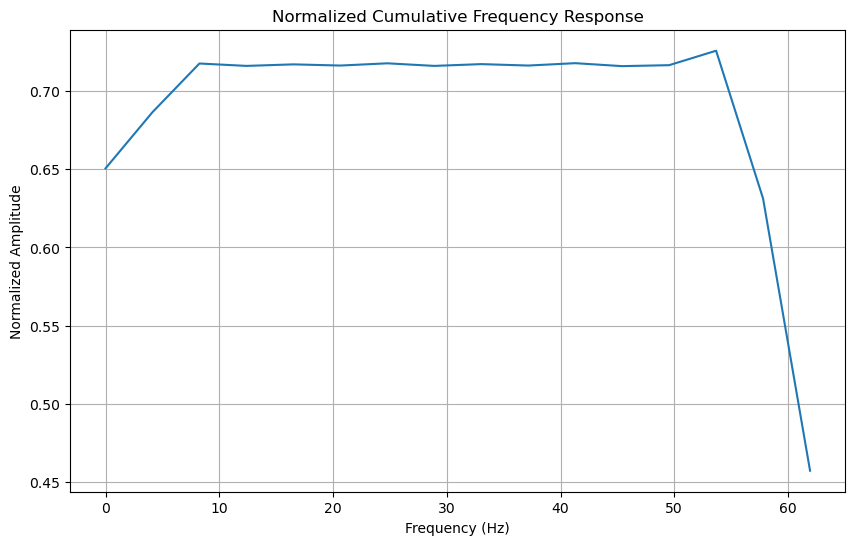

In [24]:
model = CLIPModel().to(Config.device)
eeg_Sinc = model.eeg_encoder.sinc_conv
freqs, avg_freq_response_rand = plot_frequency_response(eeg_Sinc, sample_rate=128)

In [25]:
# after Training

31
(16,)


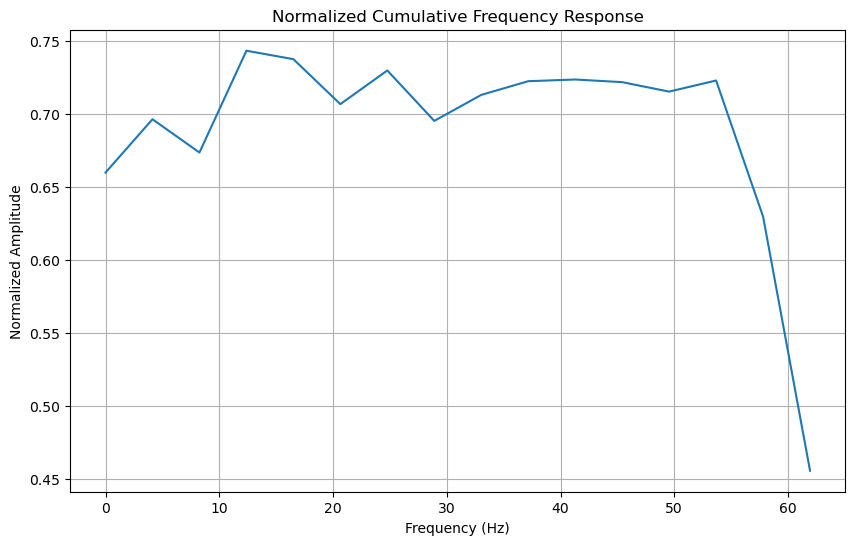

In [26]:
model = CLIPModel().to(Config.device)
# 加载模型参数
model.load_state_dict(torch.load("Cross_trails_trysomething_new_1019/S4/cross_trails_s4_best.pt"))

eeg_Sinc_1 = model.eeg_encoder.sinc_conv
freqs,avg_freq_response_learn = plot_frequency_response(eeg_Sinc_1, sample_rate=128)

In [27]:
# for all subject

Processing file: Cross_trails/S1/cross_trails_s1_best.pt
31
(16,)


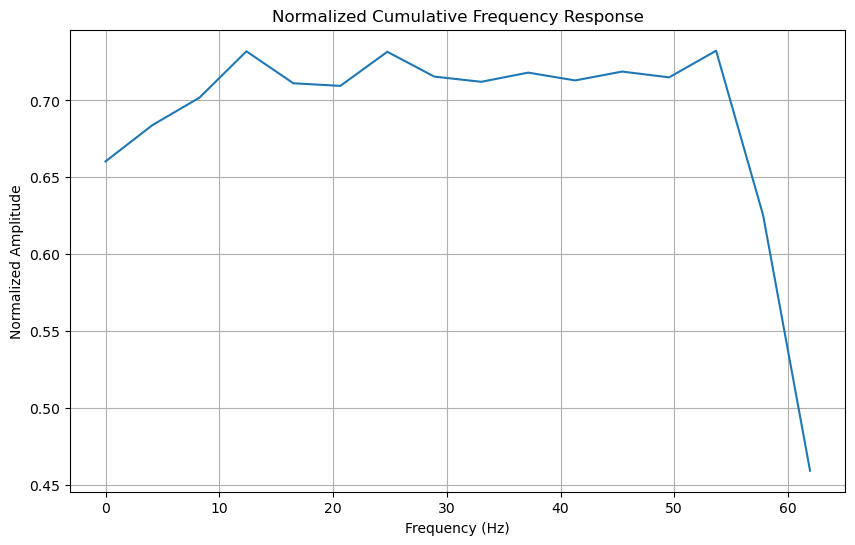

In [28]:
# Initialize an 18x16 array to store the results
results = np.zeros((18, 16))

# Iterate through folders S1 to S16
for i in range(1, 2):  # Adjust the range as needed (1 to 17 for S1 to S16)
    folder_name = f"S{i}"
    file_path = os.path.join("Cross_trails", folder_name, f"cross_trails_s{i}_best.pt")
    print(f"Processing file: {file_path}")
    
    # Check if the file exists
    if os.path.isfile(file_path):
        # Create the model and load parameters
        model = CLIPModel().to(Config.device)
        model.load_state_dict(torch.load(file_path))
        
        # Get the frequency response
        eeg_Sinc_1 = model.eeg_encoder.sinc_conv
        freqs, avg_freq_response_learn = plot_frequency_response(eeg_Sinc_1, sample_rate=128)
        
        # Save the results to the array, assuming you want to save the mean of avg_freq_response_learn
        # Here, it is assumed that avg_freq_response_learn is a one-dimensional array; adjust as needed
        results[i - 1, :len(avg_freq_response_learn)] = avg_freq_response_learn

# # Print the results
# print(results)

# # Save the results to a file (optional)
# np.save("avg_freq_response_learn_results.npy", results)

# # Save the results to a .mat file
# savemat("avg_freq_response_learn_results.mat", {"results": results})